# STAT301 Project - Final Report
## Dec 5, 2025
## Group 23

### Sarah Chan 56278500, Zewen Jin 71642011, Bryan Sun 39325758, 

## **1 Introduction**

### **1.1 Scientific Question**
I want to examine if the probability of making a purchase is associated with time of the session and the duration of visiting pages related to products.

To answer this question, the model would have variables of interests as below:
- response:`Revenue`
- covariates: `Weekend`, `Month`, `ProductRelated_Duration`

This question is focused on inference, I am exploring if there is a relationship between probability of making a purchase and session time plus duration of visits to product-related pages.

## **2 Methods and Results**

### 2.1.1 Summary of data

The dataset records sessions of online shoppers, where each session belongs to a different user in a 1-year period. There are a total of 12330 sessions(observations) and 18 variables, which are described below:

- `Administrative` (Integer): the number of administrative pages the user visited during a session
- `Administrative_Duration`	(Integer): the total time spent on administrative pages during a session	
- `Informational`	(Integer): the number of informative pages the user visited during a session
- `Informational_Duration`	(Integer): the total time spent on informative pages during a session		
- `ProductRelated`	(Integer): the number of product-related pages the user visited during a session
- `ProductRelated_Duration`	(Continuous): the total time spent on product-related pages during a session	

Note: The values of the above features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. **The unit time for the durations are not given**.

- `BounceRates`	(Continuous): the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session
- `ExitRates`	(Continuous): for all pageviews to a specific page, the percentage of the pageviews that were the last in the session
- `PageValues`	(Integer): the average value for a web page that a user visited before completing an e-commerce transaction
- `SpecialDay`	(Integer): the closeness of the site visiting time to a specific special day, determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date
- `Month`	(Categorical): the month in which the session occurred 
- `OperatingSystems`	(Integer): the type of operating system used for the session (probably encoded into integers here)
- `Browser`	(Integer): the type of browser used for the session (probably encoded into integers here)
- `Region`	(Integer): the region in which the session occurred (probably encoded into integers here)
- `TrafficType`	(Integer): the type of traffic used during the session (probably encoded into integers here)
- `VisitorType`	(Categorical): type of visitor for a page, either a returning (`Returning_visitor`) or new (`New_visitor`)
- `Weekend`	(Binary): whether or not the date of visit to a page is on a weekend	
- `Revenue`	(Binary): whether or not revenue is made, ie. if the user made a purchase	

As shown below, there are **no missing values** in the dataset.

**No data from region 1 will be used, as instructed.**

### 2.1.2 Source of data

The dataset is obtained from the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset). The data is obtained from website analytics tools, such as Google Analytics and more, collecting number of page visits, duration of visits, type of visitor, etc.

### 2.1.3 Preselection of variables

I would exclude the variables `OperatingSystems`, `Browser`, `Region`, `TrafficType` because they are already encoded into integers without a description of what each integer represents, causing lack of interpretation of these variables and the inability to make meaningful insights for these variables.

### **2.2 Exploratory Data Analysis**

The dataset is loaded in using `read.csv()` and the excluded variables are removed first using `select()`. 

The data type is checked, and I also checked if there are any missing values.

<!-- install.packages("ggpubr")
install.packages("corrplot")
install.packages("broom")
install.packages("car") -->

In [1]:
# install.packages("rsample")
# install.packages("caret")
# install.packages("glmnet")
# install.packages("pROC")

In [2]:
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(ggpubr, warn.conflicts = FALSE)
library(corrplot, warn.conflicts = FALSE)
library(car, warn.conflicts = FALSE)
library(broom, warn.conflicts = FALSE)
library(rsample, warn.conflicts = FALSE)
library(caret, warn.conflicts = FALSE)
library(glmnet, warn.conflicts = FALSE)
library(pROC, warn.conflicts = FALSE)


corrplot 0.95 loaded

Loading required package: carData

Loading required package: lattice

Loading required package: Matrix

Loaded glmnet 4.1-10

Type 'citation("pROC")' for a citation.



In [3]:
set.seed(42)

data <- read.csv("https://raw.githubusercontent.com/schan26/stat301-project/refs/heads/main/data/online_shoppers_intention.csv")

data <- data %>% filter(Region != 1) # Use data not from Region 1
# data <- data %>% select(-OperatingSystems, -Browser, -Region, - TrafficType) # Remove the excluded variables listed in section 1.3

# Change categorical variables to factor type
data$Month <- as.factor(data$Month)
data$VisitorType <- as.factor(data$VisitorType)
data$OperatingSystems <- as.factor(data$OperatingSystems)
data$Browser <- as.factor(data$Browser)
data$Region <- as.factor(data$Region)
data$TrafficType <- as.factor(data$TrafficType)


# Change response to numeric type of 0 or 1
# data$Revenue <- as.numeric(data$Revenue)

# check data type of each variable
sapply(data, class)

# check for missing values count in data frame
sum(is.na(data))

nrow(data)

Administrative Administrative_Duration           Informational 
              "integer"               "numeric"               "integer" 
 Informational_Duration          ProductRelated ProductRelated_Duration 
              "numeric"               "integer"               "numeric" 
            BounceRates               ExitRates              PageValues 
              "numeric"               "numeric"               "numeric" 
             SpecialDay                   Month        OperatingSystems 
              "numeric"                "factor"                "factor" 
                Browser                  Region             TrafficType 
               "factor"                "factor"                "factor" 
            VisitorType                 Weekend                 Revenue 
               "factor"               "logical"               "logical"

[1] 0

[1] 7550

<!--->

After removing data from Region 1, there are a total of 7550 observations left in the dataset. 

We fixed the data types, and no missing values are present in the training dataset.

In [4]:
data %>%
  summarize(count = mean(Revenue)) 

count
<dbl>
0.150596


We can observe a severe class imbalance in `Revenue`, which is expected since many shoppers simply browse but not make a purhase in the end. 

To account for this, we would use AUC as the scoring metric during model selection.

We split the dataset into training and testing set using a 70-30 split. EDA and fitting will be done on training set, and the test set is not peaked at until final assess of model performance.

In [5]:
# Split data into train and test set
data_split <- data %>% initial_split(prop = 0.7, strata = Revenue)
training <- training(data_split)
testing <- testing(data_split) # Used only after all EDA and fitting

head(training)
nrow(training)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,0,0,0,0,2,2.666667,0.050000000,0.14000000,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
2,0,0,0,0,1,0.000000,0.200000000,0.20000000,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,FALSE
3,0,0,0,0,2,37.000000,0.000000000,0.10000000,0,0.8,Feb,2,2,2,3,Returning_Visitor,FALSE,FALSE
4,0,0,0,0,2,68.000000,0.000000000,0.10000000,0,0.0,Feb,3,2,3,3,Returning_Visitor,FALSE,FALSE
5,2,53,0,0,23,1668.285119,0.008333333,0.01631264,0,0.0,Feb,1,1,9,3,Returning_Visitor,FALSE,FALSE
6,0,0,0,0,1,0.000000,0.200000000,0.20000000,0,0.0,Feb,1,1,4,3,Returning_Visitor,FALSE,FALSE


[1] 5284

Here are the summary statistics for each variables:

In [6]:
summary(training)
# count of observations for each category for the categorical variables
training %>% count(Month)
training %>% count(VisitorType)
training %>% count(Browser)

 Administrative   Administrative_Duration Informational    
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.0000  
 Median : 1.000   Median :  11.00         Median : 0.0000  
 Mean   : 2.357   Mean   :  83.27         Mean   : 0.4595  
 3rd Qu.: 4.000   3rd Qu.:  98.42         3rd Qu.: 0.0000  
 Max.   :27.000   Max.   :2156.17         Max.   :14.0000  
                                                           
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  187.7        
 Median :   0.00        Median : 18.00   Median :  598.8        
 Mean   :  32.42        Mean   : 30.53   Mean   : 1148.4        
 3rd Qu.:   0.00        3rd Qu.: 37.00   3rd Qu.: 1462.0        
 Max.   :2252.03        Max.   :584.00   Max.   :24844.2        
                                                                


Month,n
<fct>,<int>
Aug,190
Dec,784
Feb,74
Jul,197
June,134
Mar,791
May,1510
Nov,1176
Oct,226


VisitorType,n
<fct>,<int>
New_Visitor,726
Other,49
Returning_Visitor,4509


Browser,n
<fct>,<int>
1,976
2,3439
3,40
4,339
5,210
6,72
7,24
8,64
9,1


Interestingly, there are no sessions recorded in January or April.

There are also another type of visitor that is not included in data description values.

For `Browser`, some levels have very little observations, which could lead to model instability later on. We will see if this is the case in later sections.

There could be extreme outliers for the duration of page visits (`Administrative_Duration`, `Informational_Duration`,`ProductRelated_Duration`), seen by comparing the median and the max of these variables

`summarise()` has grouped output by 'Month'. You can override using the `.groups` argument.


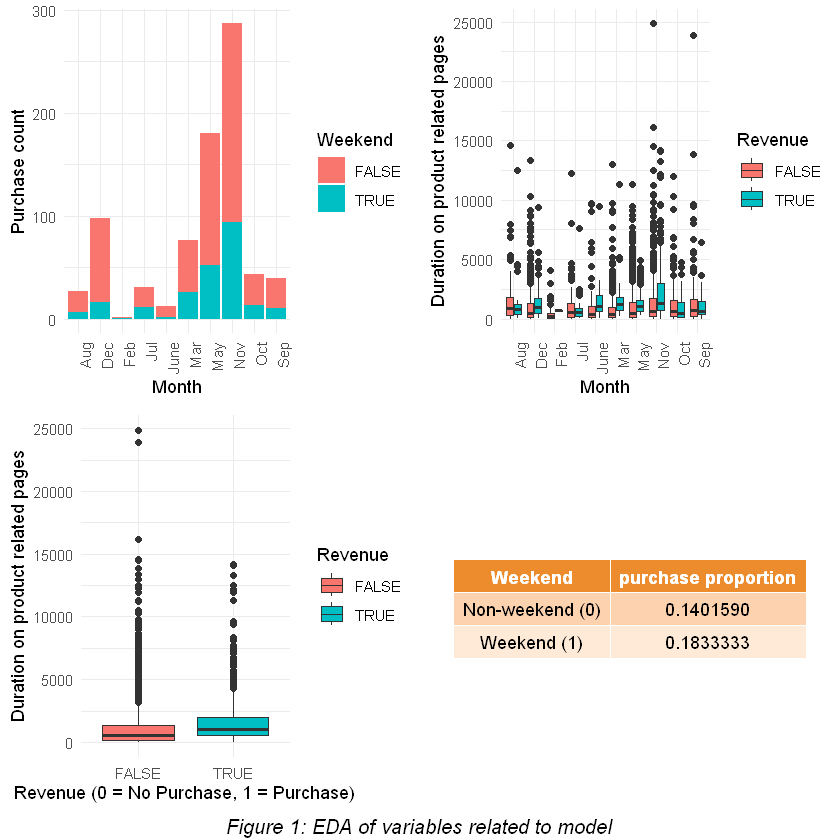

In [7]:
# Plot of Revenue against Month and ProductRelated_Duration
rev_month_dur <- ggplot(training, aes(x = Month, y = ProductRelated_Duration)) +
  geom_boxplot(aes(fill = Revenue)) +
  labs(
    x = "Month",
    y = "Duration on product related pages"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

# Plot of Revenue against Month and Weekend
rev_month_we_sum <- training %>%
  group_by(Month, Weekend) %>%
  summarize(count = sum(Revenue)) 

rev_month_we <- ggplot(rev_month_we_sum, aes(x = Month, y = count, fill=Weekend)) +
  geom_bar(stat="identity",position="stack") +
  labs(
    x = "Month",
    y = "Purchase count",
  ) +
  theme_minimal()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) 

# Table of Revenue against Weekend using proportion of successful purchases
weekend_sum <- training %>%
  group_by(Weekend) %>%
  summarize("purchase proportion" = mean(Revenue)) %>%
  mutate(Weekend = if_else(Weekend == 0, "Non-weekend (0)", "Weekend (1)"))
weekend_table <- ggtexttable(weekend_sum, rows = NULL, 
                        theme = ttheme("mOrange"))


# Plot of Revenue against ProductRelated_Duration
rev_dur <- ggplot(training, aes(x = Revenue, y = ProductRelated_Duration)) +
  geom_boxplot(aes(fill=Revenue)) +
  labs(
    x = "Revenue (0 = No Purchase, 1 = Purchase)",
    y = "Duration on product related pages",
  ) +
  theme_minimal()

# combine above plots into one plot using ggarrange from ggpubr library
plot <- ggarrange(rev_month_we, rev_month_dur, rev_dur,  weekend_table , 
          ncol = 2, nrow = 2)
annotate_figure(plot,
                bottom = text_grob("Figure 1: EDA of variables related to model", 
                                   color = "black", face = "italic", size = 12))

*Remark: I used proportion of purchases for visualizing the relationship between `Weekend` and `Revenue` because there are imbalance of number of days for weekend and non-weekend (2 days and 5 days respectively, which would give misleading results if I simply plot the raw counts).*

From Figure 1:

- I believe this plot is relevant to my question because it shows exploration of the potential relationships between the covariates (or interaction of covariates) and the response variable. Visualizing the variables could help with making an initial identification of which covariates are associated with probability of making a purchase.
- The first plot in the figure shows that the number of purchases in December, March, May, and November is much higher compared to other months. In addition, the second plot shows that the duration on product-related pages for succussful purchases is noticeably higher in November and March compared to other months. Therefore, these two plots suggests that the probability of making a purchase could  vary across each month.
- From the visualization, I can see that there are extreme outliers for `ProductRelated_Duration`, which could impair our model as these could greatly influence the linear model. Moreover, there is very little data for the revenue count in February, so the estimates in the model for February may be unreliable or biased. 

### **2.3 Methods: Plan**

I will use **logistic regression** because my research question is about understanding the relationship between online purchases and session features. The repsonse variable `revenue` is a binary variable, so this method is appropraiate for this context since it can map probability of successful online purchases to binary outcomes, and the probability is dependent on session features. Moreover, logistic regression allows for interpretable coefficient estimates in terms of likelihood or probabilities of successful online purchases.

**Assumptions**: 
Logistic regression assumes that the observations are independent, the response is binary, and that the log-odds of online purchases has a linear relationship with the session features. It also assumes that there is no multicollinearity issue between the covariates. 

**Limitations**:
This model cannot capture non-linear relationships between log-odds of online purchases and session features unless data transformation or interaction terms is introduced. It is also sensitive to outliers. In addition, if the observations are not independent or multicollinearity is present, the standard errors would be inflated, which would lead to unreliable p-values so that statistical inference are invalid.

### **2.4 Computational Code and Results**

#### **2.4.1 Preliminary Model**

For a initial model, I will fit an ordinary logistic regression model with all session features.

However, some variables are first removed due to redundancy and multicollinearity issues. As stated in section 1.3, `OperatingSystems`, `Browser`, `Region`, `TrafficType` are excluded already since their values do not have meaningful descriptions. Only data not from region 1 is used as well.  

Potential correlated numeric covariates is first explored, I will use 0.6 as a threshold:

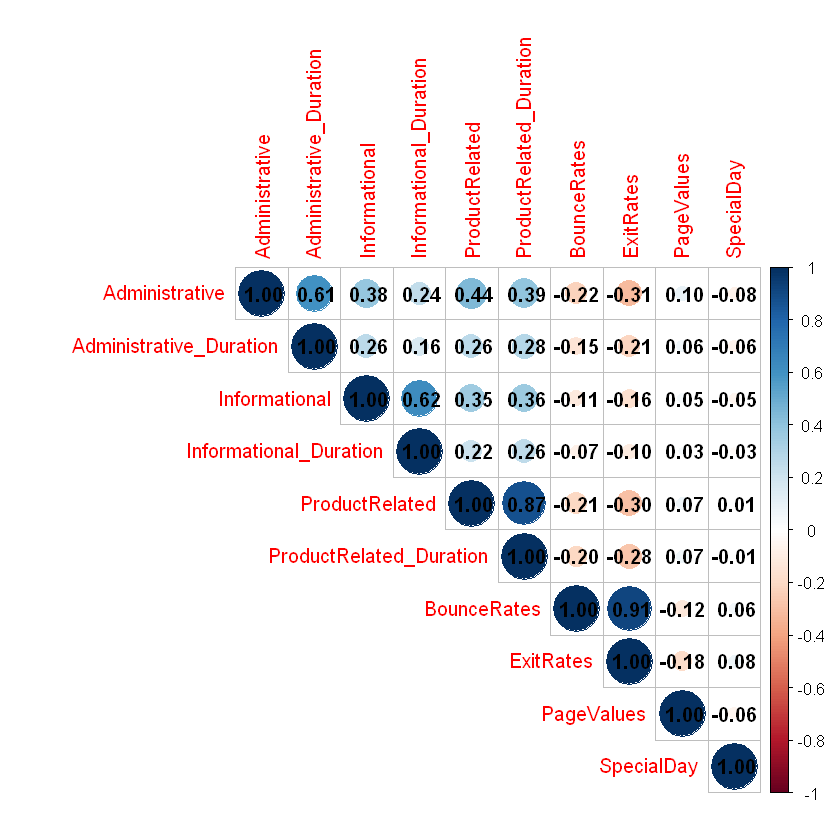

In [8]:
# plotting the correlation plot for numeric variables
numeric_data <- training[sapply(training, is.numeric)]
cor_mat <- cor(numeric_data, use = "complete.obs")

corrplot(cor_mat,
         type = "upper",       
         addCoef.col = "black" 
)

From the correlation plot, it can be seen that `BounceRates` and `ExitRates`, `ProductRelated` and `ProductRelated_Duration`, `Informational` and `Informational_Duration`, `Administrative` and `Administrative_Duration`, all have correlation more than 0.6. 

Therefore, I would remove the variables `BounceRates` since it's less informative than `ExitRates` (reflects end-of-session behavior of shoppers), and `ProductRelated`, `Informational`, `Administrative` as these variables are counts of pages visited, which is less interpretable than time spent. 

After removing the correlated variables, I changed the categorical variables into factor types for model fitting. The model is then fitted on the remaining variables and multicollinearity issues is checked.

In [9]:
# Remove the correlated variables
uncor_training <- training %>% select(-BounceRates, -ProductRelated, -Informational, -Administrative)

In [10]:
# fit 1st model
model <- glm(Revenue ~ ., uncor_training, family = "binomial")

# check vif for multicollinearity issue
alias(model)

Model :
Revenue ~ Administrative_Duration + Informational_Duration + 
    ProductRelated_Duration + ExitRates + PageValues + SpecialDay + 
    Month + OperatingSystems + Browser + Region + TrafficType + 
    VisitorType + Weekend

Complete :
          (Intercept) Administrative_Duration Informational_Duration
Browser11 0           0                       0                     
          ProductRelated_Duration ExitRates PageValues SpecialDay MonthDec
Browser11 0                       0         0          0          0       
          MonthFeb MonthJul MonthJune MonthMar MonthMay MonthNov MonthOct
Browser11 0        0        0         0        0        0        0       
          MonthSep OperatingSystems2 OperatingSystems3 OperatingSystems4
Browser11 0        0                 0                 0                
          OperatingSystems5 OperatingSystems6 OperatingSystems7
Browser11 1                 0                 0                
          OperatingSystems8 Browser2 Browser3 Br

As above, there are levels of `Browser` that is aliased with other covariates, which implies perfect multicollinearity with some other covariates. This could be due to some levels of `Browser` having little observations as noted in Section 2.2. Therefore, we decided to drop this variable in the model.

In [11]:
uncor_training <- uncor_training %>% dplyr::select(-Browser)

model <- glm(Revenue ~ ., uncor_training, family = "binomial")

# check vif for multicollinearity issue
 car::vif(model)

,GVIF,Df,GVIF^(1/(2*Df))
Administrative_Duration,1.133513,1,1.064666
Informational_Duration,1.103109,1,1.050290
ProductRelated_Duration,1.307619,1,1.143512
ExitRates,1.179350,1,1.085979
PageValues,1.092075,1,1.045024
SpecialDay,1.227012,1,1.107706
Month,1.881983,9,1.035754
OperatingSystems,2.335673,7,1.062466
Region,1.181771,7,1.012001
TrafficType,2.210841,17,1.023609


The VIF of each variable is less than 5, so there is **no** sign of multicollinearity issues. This model would be our preliminary prediction model.

#### **2.4.2 Model Selection Using LASSO and RIDGE**

In [12]:
# Preparing X and y matrix for glmnet
model_X_train <- model.matrix(Revenue ~ ., data = training)[,-1]
matrix_Y_train <- as.matrix(training$Revenue, ncol=1)

In [13]:
set.seed(42)

# Perform 10-fold CV using LASSO, optimizing for AUC
lasso <- 
  cv.glmnet(
  x = model_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  type.measure = "auc",
  nfolds = 10)

# Perform 10-fold CV using Ridge, optimizing for AUC
ridge <- 
  cv.glmnet(
  x = model_X_train, y = matrix_Y_train,
  alpha = 0,
  family = "binomial",
  type.measure = "auc",
  nfolds = 10)

lasso
ridge


Call:  cv.glmnet(x = model_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.04041    17  0.9114 0.00683       3
1se 0.04041    17  0.9114 0.00683       3


Call:  cv.glmnet(x = model_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

     Lambda Index Measure       SE Nonzero
min 0.01790   100  0.8930 0.005951      65
1se 0.07932    84  0.8873 0.005702      65

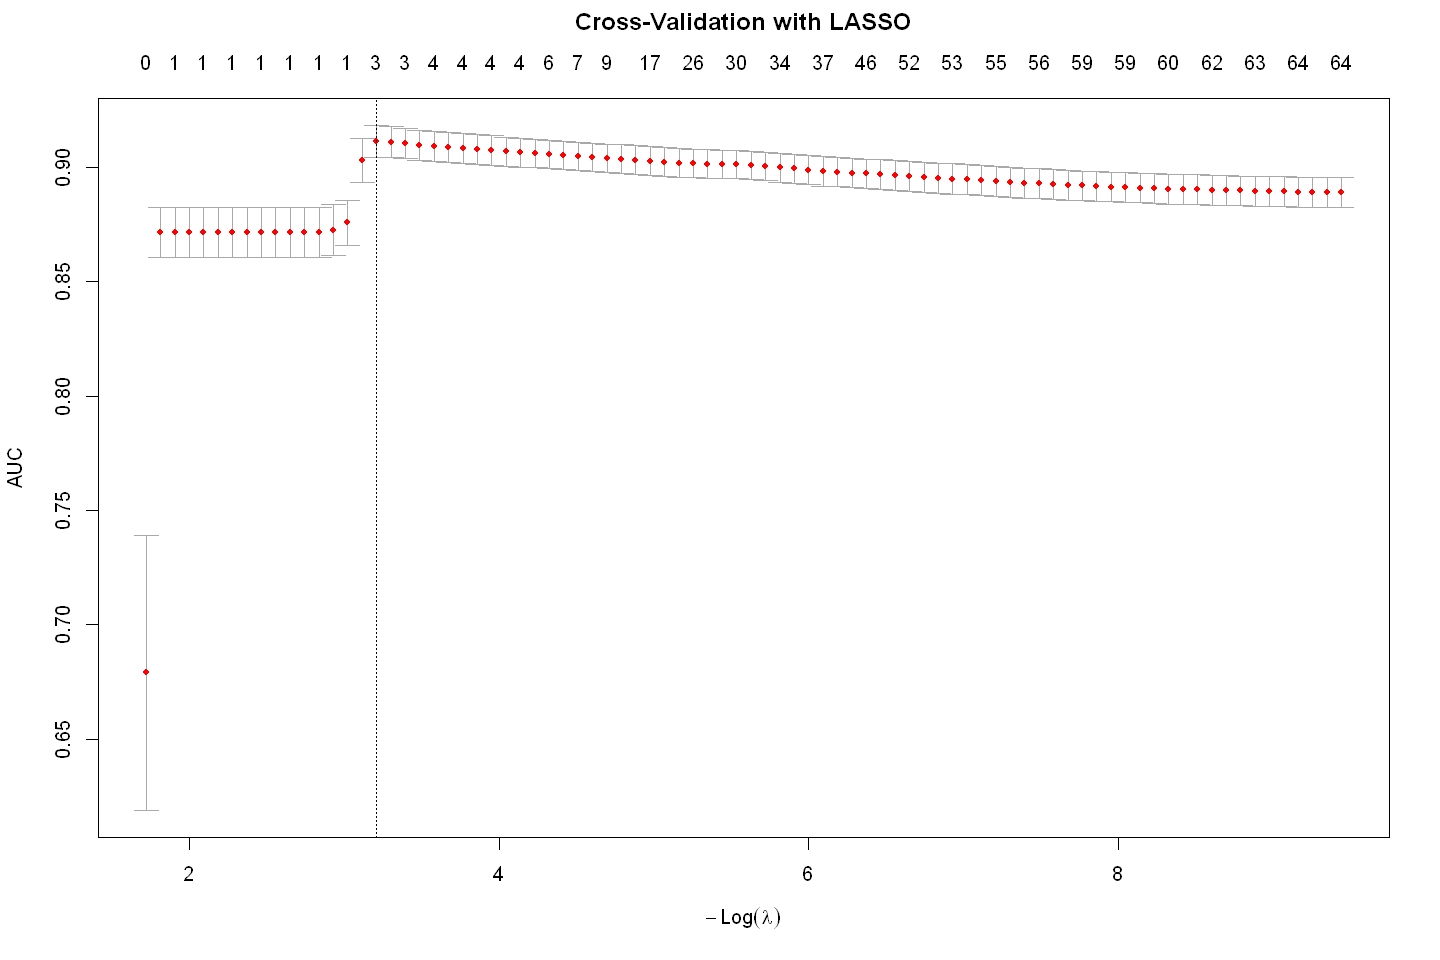

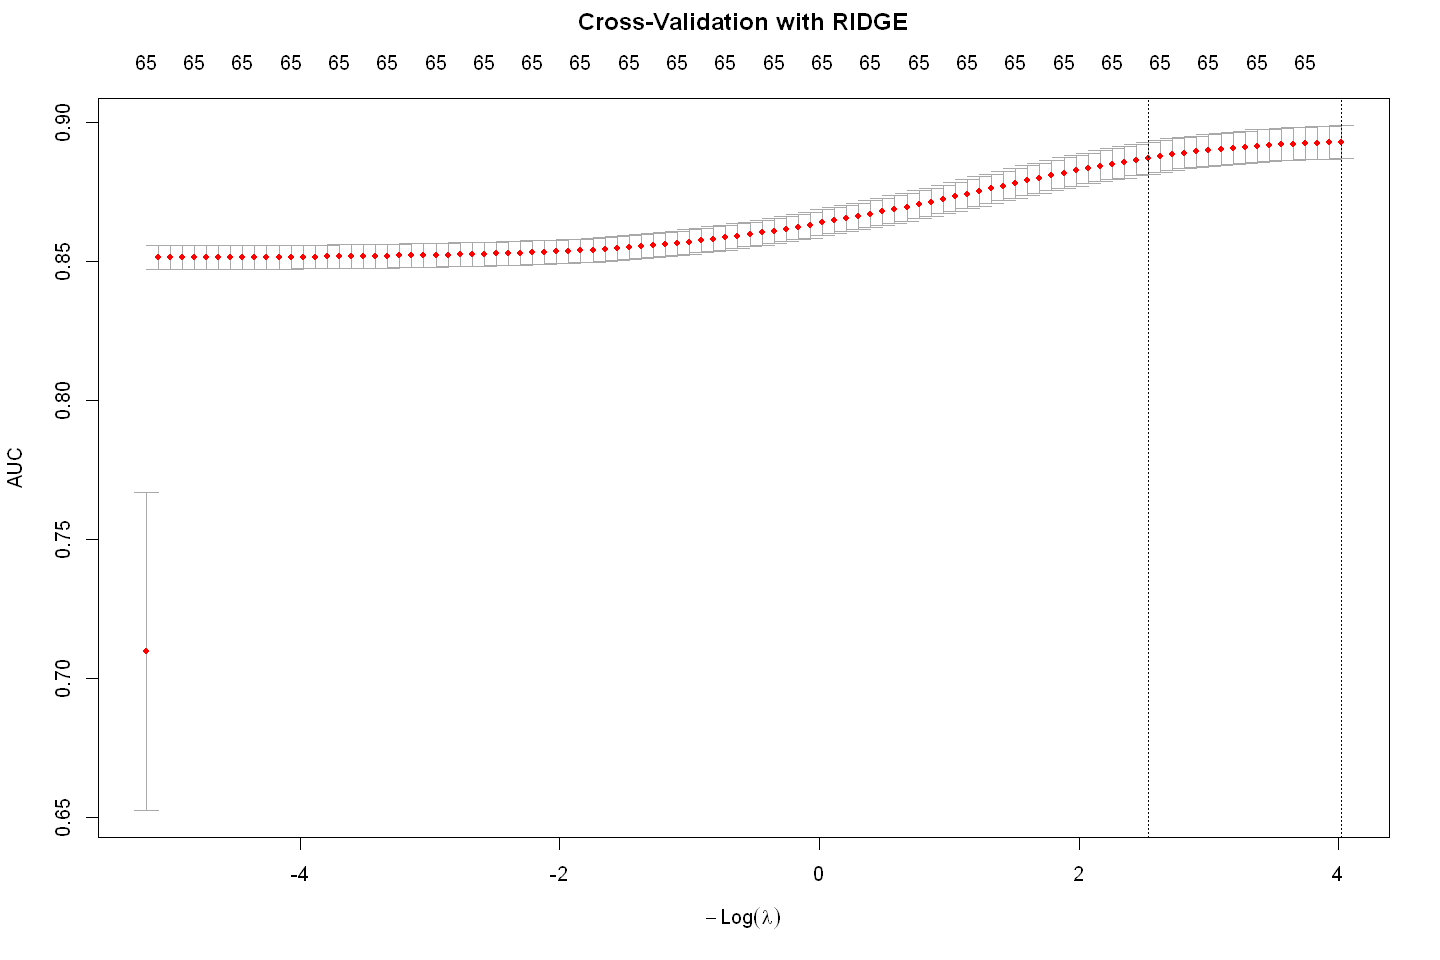

In [14]:
options(repr.plot.width = 12, repr.plot.height = 8)

plot(lasso, main = "Cross-Validation with LASSO\n\n")
plot(ridge, main = "Cross-Validation with RIDGE\n\n")


In [15]:
# Extract best lambda that maximizes AUC
lambda_max_AUC_lasso <- round(lasso$lambda.min, 4)
lambda_max_AUC_lasso

lambda_max_AUC_ridge <- round(ridge$lambda.min, 4)
lambda_max_AUC_ridge

[1] 0.0404

[1] 0.0179

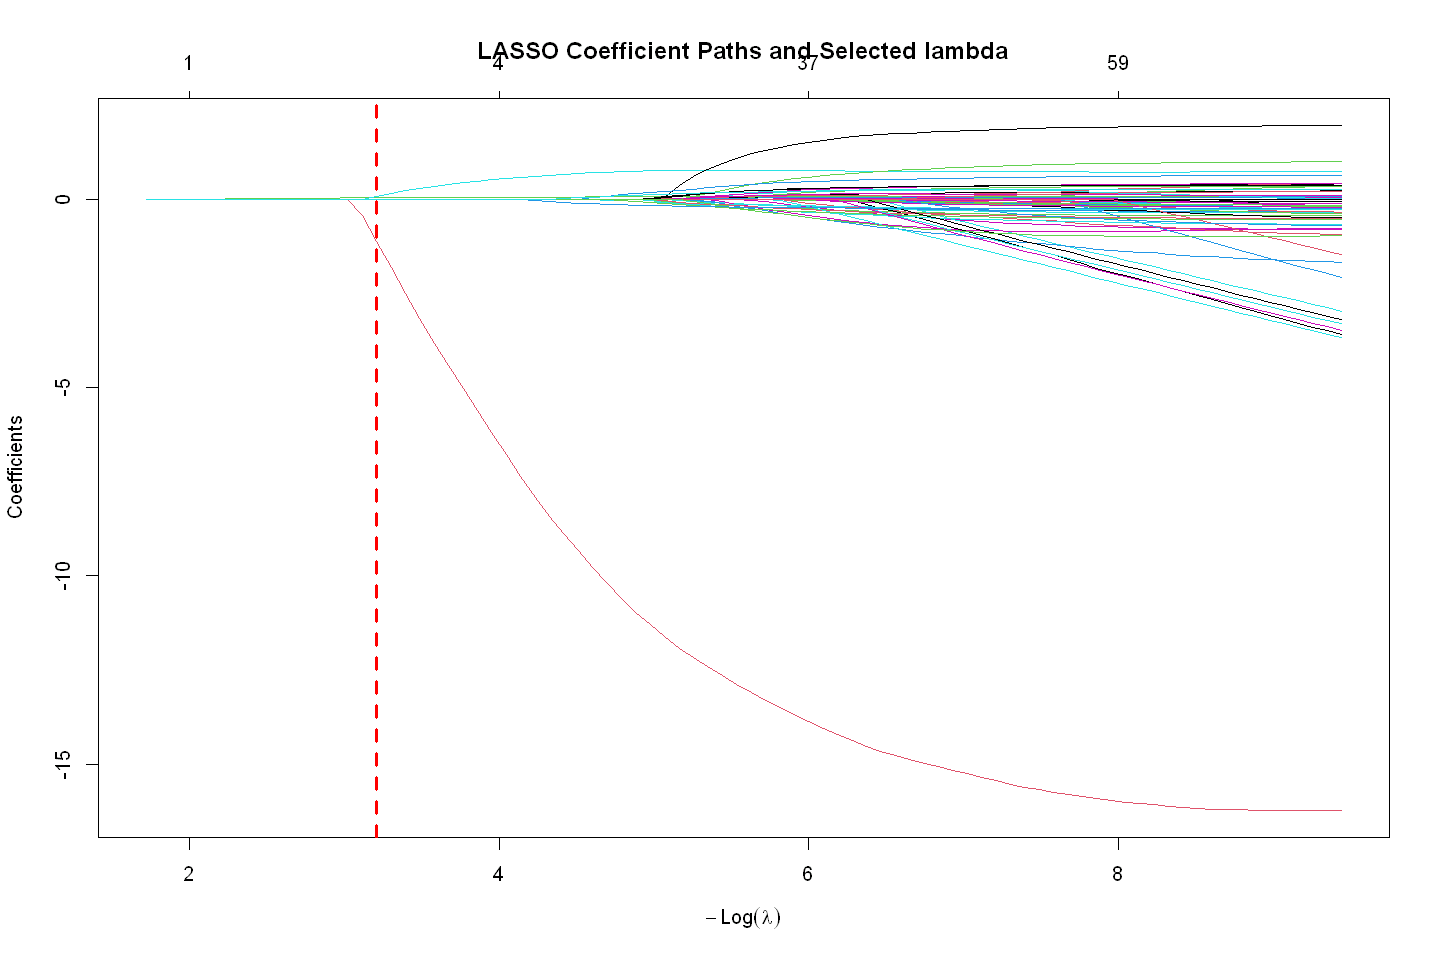

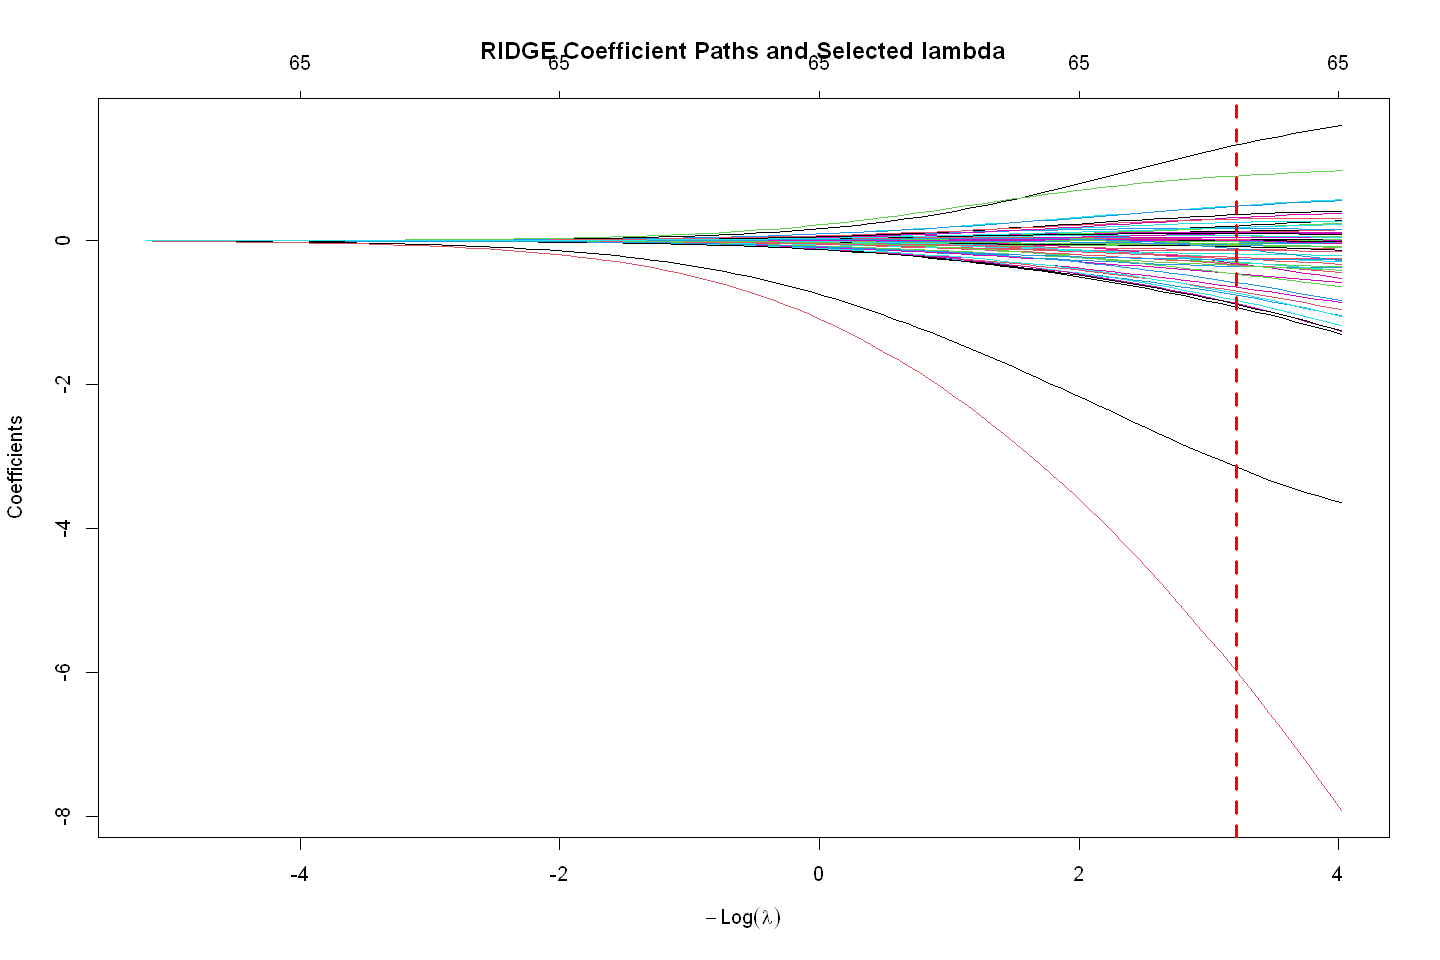

In [16]:
plot(lasso$glmnet.fit, "lambda",
    main = "LASSO Coefficient Paths and Selected lambda") 
abline(v = -log(lambda_max_AUC_lasso), col = "red", lwd = 3, lty = 2) 

plot(ridge$glmnet.fit, "lambda",
    main = "RIDGE Coefficient Paths and Selected lambda") 
abline(v = -log(lambda_max_AUC_lasso), col = "red", lwd = 3, lty = 2) 

In [17]:
# Obtaining our final model using the best lambda
final_lasso <- glmnet(
  x = model_X_train,
  y = matrix_Y_train,
  alpha = 1,
  lambda = lambda_max_AUC_lasso,
  family = "binomial"
)


final_ridge <- glmnet(
  x = model_X_train,
  y = matrix_Y_train,
  alpha = 0,
  lambda = lambda_max_AUC_ridge,
  family = "binomial"
)

final_lasso
final_ridge


Call:  glmnet(x = model_X_train, y = matrix_Y_train, family = "binomial",      alpha = 1, lambda = lambda_max_AUC_lasso) 

  Df  %Dev Lambda
1  3 24.21 0.0404


Call:  glmnet(x = model_X_train, y = matrix_Y_train, family = "binomial",      alpha = 0, lambda = lambda_max_AUC_ridge) 

  Df  %Dev Lambda
1 65 31.93 0.0179

In [18]:
coefs_lasso <- coef(final_lasso)
coefs_ridge <- coef(final_ridge)

coefs_lasso
coefs_ridge

67 x 1 sparse Matrix of class "dgCMatrix"
                                      s0
(Intercept)                  -2.15652472
Administrative                .         
Administrative_Duration       .         
Informational                 .         
Informational_Duration        .         
ProductRelated                .         
ProductRelated_Duration       .         
BounceRates                   .         
ExitRates                    -1.11846886
PageValues                    0.05415008
SpecialDay                    .         
MonthDec                      .         
MonthFeb                      .         
MonthJul                      .         
MonthJune                     .         
MonthMar                      .         
MonthMay                      .         
MonthNov                      0.10073973
MonthOct                      .         
MonthSep                      .         
OperatingSystems2             .         
OperatingSystems3             .         
OperatingSystem

67 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
(Intercept)                  -2.052799e+00
Administrative                1.596818e-02
Administrative_Duration       3.554301e-05
Informational                -2.878754e-02
Informational_Duration        3.999826e-04
ProductRelated                1.781608e-04
ProductRelated_Duration       7.252561e-05
BounceRates                  -3.633997e+00
ExitRates                    -7.912970e+00
PageValues                    6.339062e-02
SpecialDay                   -3.776760e-01
MonthDec                     -2.857262e-01
MonthFeb                     -5.725557e-01
MonthJul                      2.787955e-01
MonthJune                    -9.741155e-02
MonthMar                     -3.609875e-01
MonthMay                     -2.554524e-02
MonthNov                      5.761239e-01
MonthOct                      4.130505e-02
MonthSep                      1.599028e-01
OperatingSystems2             1.524843e-01
OperatingSys

In [19]:
# Preparing X and y of test set for glmnet
model_X_test <- 
    model.matrix(object = Revenue ~ .,
                 data = testing)[, -1]

testing$Revenue <- as.numeric(testing$Revenue)

matrix_Y_test <- 
    as.matrix(testing$Revenue, ncol = 1)

For the preliminary model, there were issues with predictions because of a new level (16) in `TrafficType` that didn't appear in the training set:

In [20]:
testing %>% 
summarize(count = sum(TrafficType == 16))

count
<int>
1


Since there is only one observation with this level of `TrafficType`, we are going to simply remove this test example for simplicity. There are more than 2000 test examples, so there is negligible effect on model evaluation for removing one test example.

In [21]:
test_data_prelim <- testing %>% filter(TrafficType != 16)

In [22]:
# Predict probabilities on the test set

p_0 <- 0.3  # Threshold at 0.3
pred_lasso <-  ifelse(predict(final_lasso, model_X_test, type="response") >= p_0, 1, 0)
pred_ridge <-  ifelse(predict(final_ridge, model_X_test, type="response") >= p_0, 1, 0)
pred_prelim <-  ifelse(predict(model, test_data_prelim, type="response") >= p_0, 1, 0)


In [23]:
# Check the performance of the final model on test set using confusion matrix
conf_mat_lasso <- 
    confusionMatrix(
    data = as.factor(pred_lasso),
    reference = as.factor(matrix_Y_test),
    positive = "1"
)
conf_mat_lasso

conf_mat_ridge <- 
    confusionMatrix(
    data = as.factor(pred_ridge),
    reference = as.factor(matrix_Y_test),
    positive = "1"
)
conf_mat_ridge

conf_mat_prelim <- 
    confusionMatrix(
    data = as.factor(pred_prelim),
    reference = as.factor(test_data_prelim$Revenue),
    positive = "1"
)
conf_mat_prelim

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1881  213
         1   43  129
                                          
               Accuracy : 0.887           
                 95% CI : (0.8733, 0.8998)
    No Information Rate : 0.8491          
    P-Value [Acc > NIR] : 9.723e-08       
                                          
                  Kappa : 0.446           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.37719         
            Specificity : 0.97765         
         Pos Pred Value : 0.75000         
         Neg Pred Value : 0.89828         
             Prevalence : 0.15093         
         Detection Rate : 0.05693         
   Detection Prevalence : 0.07590         
      Balanced Accuracy : 0.67742         
                                          
       'Positive' Class : 1               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1848  177
         1   76  165
                                         
               Accuracy : 0.8883         
                 95% CI : (0.8747, 0.901)
    No Information Rate : 0.8491         
    P-Value [Acc > NIR] : 3.417e-08      
                                         
                  Kappa : 0.5042         
                                         
 Mcnemar's Test P-Value : 3.238e-10      
                                         
            Sensitivity : 0.48246        
            Specificity : 0.96050        
         Pos Pred Value : 0.68465        
         Neg Pred Value : 0.91259        
             Prevalence : 0.15093        
         Detection Rate : 0.07282        
   Detection Prevalence : 0.10635        
      Balanced Accuracy : 0.72148        
                                         
       'Positive' Class : 1              
                                         

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1837  165
         1   86  177
                                          
               Accuracy : 0.8892          
                 95% CI : (0.8755, 0.9018)
    No Information Rate : 0.849           
    P-Value [Acc > NIR] : 1.663e-08       
                                          
                  Kappa : 0.5224          
                                          
 Mcnemar's Test P-Value : 8.509e-07       
                                          
            Sensitivity : 0.51754         
            Specificity : 0.95528         
         Pos Pred Value : 0.67300         
         Neg Pred Value : 0.91758         
             Prevalence : 0.15099         
         Detection Rate : 0.07815         
   Detection Prevalence : 0.11611         
      Balanced Accuracy : 0.73641         
                                          
       'Positive' Class : 1               
                        

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



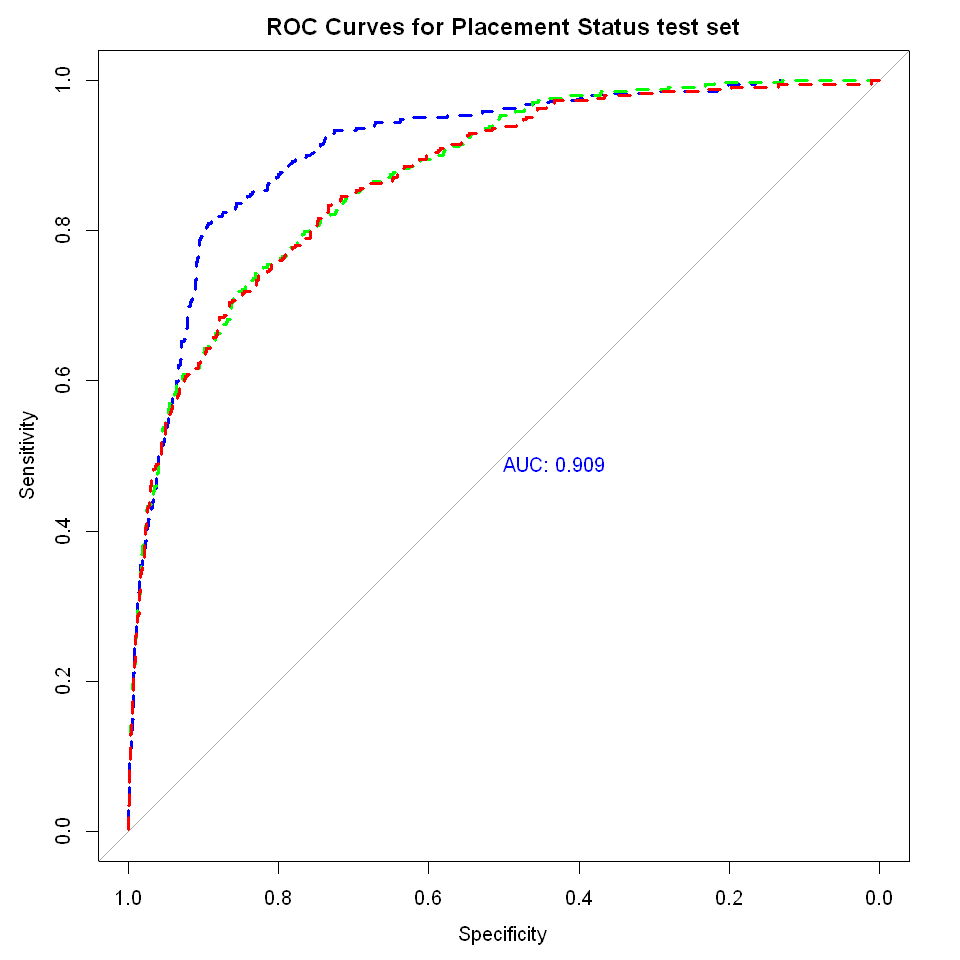

In [24]:
options(repr.plot.width = 8, repr.plot.height = 8)
ROC_lasso <- 
    roc(
        response = testing$Revenue,
        predictor = predict(final_lasso,
                     newx = model_X_test)[,"s0"] ) 
ROC_ridge <- 
    roc(
        response = testing$Revenue,
        predictor = predict(final_ridge,
                     newx = model_X_test)[,"s0"] ) 

ROC_prelim <- 
    roc(
        response = test_data_prelim$Revenue,
        predictor = predict(model,
                     newdata = test_data_prelim) ) 

# plot ROC curve
plot(ROC_lasso, print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
     main = "ROC Curves for Placement Status test set")
lines.roc(ROC_ridge, print.auc = TRUE, col = "green", lwd = 3, lty = 2)
lines.roc(ROC_prelim, print.auc = TRUE, col = "red", lwd = 3, lty = 2)